In [1]:
import impaintingLib as imp
import re

from torch.utils.tensorboard import SummaryWriter
import torch 

matcher = r"model=(\S+) +loss=(\S+,{0,1})+"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainloader, testloader = imp.data.getFaces(shuffle=False)
alterFunc = imp.mask.Alter(min_cut=4, max_cut=60, seed=0).squareMask

torch.manual_seed(0)

def modelMatch(model):
    
    if "autoenco" in model :
        res = imp.model.AutoEncoder().to(device)
    elif "unet" in model :
        if "dilat" in model :
            res = imp.model.UNet(convType="dilated").to(device)
        else : 
            res = imp.model.UNet().to(device)
    elif "partial" in model :
        res = imp.model.UNet(netType="partial").to(device)
    elif "subpix" in model :
        res = imp.model.SubPixelNetwork().to(device)
        
    else :
        print("ERREUR : AUCUN MODELE RECONNUE DANS {}".format(model))
        
    return res

def lossMatch(loss):
    
    if "l1" in loss :
        res = torch.nn.L1Loss()
    elif "l2" in loss :
        res = torch.nn.MSELoss()
    elif "vgg" in loss :
        res = imp.loss.perceptualVGG
    elif "ae" in loss :
        res = imp.loss.perceptualAE
    elif "totalvar" in loss :
        res = imp.loss.totalVariation
        
    else :
        print("ERREUR : AUCUNE LOSS RECONNUE DANS {}".format(loss))
        
    return res

def parse(expeName = 'basic'):

    count = 0
    path = "./routines/" + expeName + ".txt"
    doSave = False
    onlyTest = False
    
    with open(path) as file:
        lines = file.readlines()

    for i,line in enumerate(lines):
        line = line.strip()

        # 1ere ligne = epoch et param
        if i < 1 :
            lineSplit = line.split(",")
            epoch = int(lineSplit[0])
            
            if "save" in lineSplit:
                doSave = True
                
            if "test" in lineSplit:
                onlyTest = True

        # autres lignes = scenario
        elif line and line[0] != "#" :
            model,losses = re.search(matcher, line).groups()
            losses = losses.split(",")
            losses = [x.capitalize() for x in losses]
            runName = "{} {} Epoch{}".format(model.capitalize()," + ".join(losses),epoch)
            
            print("------ Scénario {} : {}".format(count,runName))
            count += 1

            criterions = []
            for loss in losses :
                loss = loss.split("*")
                if len(loss) < 2 :
                    loss = ["1"] + loss
                    
                loss[0] = int(loss[0])
                loss[1] = lossMatch(loss[1].lower())
                criterions.append(loss)
            
            model      = modelMatch(model.lower())
            optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
            visu       = imp.utils.Visu(runName = runName, expeName=expeName, save=doSave)
            
            # Train
            if not onlyTest : 
                print("- Train")
                visuFuncs = [#visu.board_loss_train
                            ]
                imp.process.train(model, optimizer, trainloader, criterions, epochs=epoch, alter=alterFunc, visuFuncs=visuFuncs)

                if doSave:
                    imp.process.model_save(model,runName)
            
            # Test
            if onlyTest : 
                model = imp.process.model_load(model,runName)
            
            print("- Test")
            
            visuFuncs = [#visu.board_loss_test,
                         #visu.board_plot_img,
                         visu.plot_res_img
                        ]
            imp.process.test(model, testloader, alter=alterFunc, visuFuncs=visuFuncs)

------ Scénario 0 : Autoencoder L1 Epoch1
- Train


  0%|          | 0/375 [00:00<?, ?it/s]

- Test


  0%|          | 0/39 [00:00<?, ?it/s]

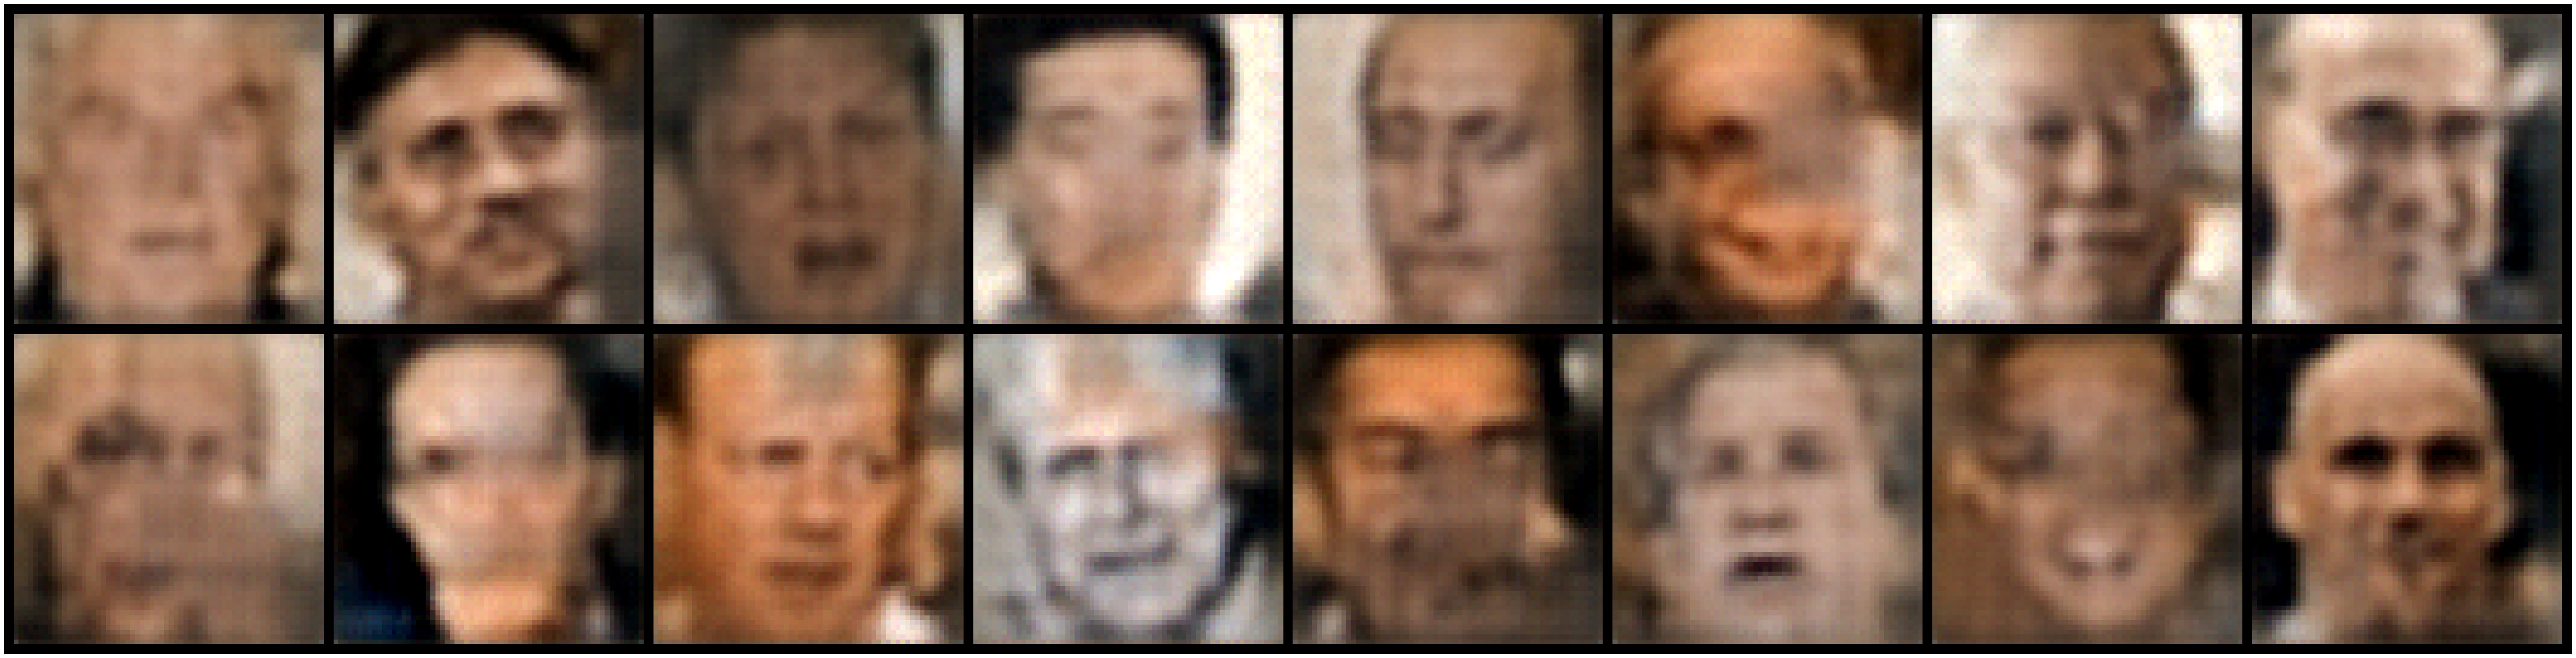

In [2]:
parse("basic")